<div class="alert alert-info">
<u><strong>Authors:</strong></u> <b>Alberto Vavassori</b> (alberto.vavassori@polimi.it), <b>Emanuele Capizzi</b> (emanuele.capizzi@polimi.it) - DICA - Politecnico di Milano - GIS GEOLab <br>
Developed within the LCZ-ODC project, funded by the Italian Space Agency (agreement n. 2022-30-HH.0).
</div>

# Principal Component Analysis (PCA) on PRISMA imagery

<a id='TOC_TOP'></a>
Notebook structure:  <br>
 1. [Import useful libraries and PRISMA coregistered image](#sec1)  
 2. [Perform the PCA with scikit-learn](#sec2)
 3. [Plot the results of the PCA](#sec3)
 4. [Export the PCs to a GeoTIFF file](#sec4)
<hr>

This Notebook provides a framework to perform a Principal Component Analysis (PCA) on hyperspectral PRISMA imagery, using the built-in `PCA` module of [*scikit-learn*](https://pypi.org/project/scikit-learn/) Python library.

Here are useful links to the complete documentation of [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [user guide](https://scikit-learn.org/stable/modules/decomposition.html#pca).

<div class="alert alert-warning"> <b>NOTE:</b> We provide a brief description of the main ingredients of the PCA. More information can be found in the following paper.

[Gewers, F.L. et al. Principal Component Analysis: A Natural Approach to Data Exploration. *ACM Computing Surveys* **2021**, 54(4), 1-34](https://dl.acm.org/doi/abs/10.1145/3447755?casa_token=8iuGBM-LOuwAAAAA:F6mom3VkMHcAmg6K41X89Ulsd8EfLdLcWK0wMEEB-RQxULggL24ygEVxrHiGRb3SGVc547cfuJwzIA)</span> 

</div>

The PCA basically consists in transforming the original data stored in the matrix $X$ to a new set of data $Y$ which is rotated according to a matrix $W$:

$Y = WX$

The original data $X$ has a covariance matrix $K = {1\over(p-1)}X'X$, where $p$ is the number of samples. The rotation aims to generate a new variable $Y$ whose covariance matrix $\Lambda$ is diagonal, meaning that the new variables $y_j$ are uncorrelated. This implies that $Kw_j = \lambda_j w_j$ for every column $w_j$ of $W$ ($\lambda_j$ is the j-th column of $\Lambda$). Equivalently, the operation consists in finding eigenvalues and eigenvectors of the covariance matrix $K$ of $X$. Specifically, ${\sigma_{y_j}}^2 = \lambda_{y_j}$ (in other words, the eigenvalues represent the variances of the new variables $y_j$). Furthermore, $W$ is the eigenvectors matrix. The j-th column of the resulting matrix $Y$ contains the scores of the j-th principal component $y_j$.

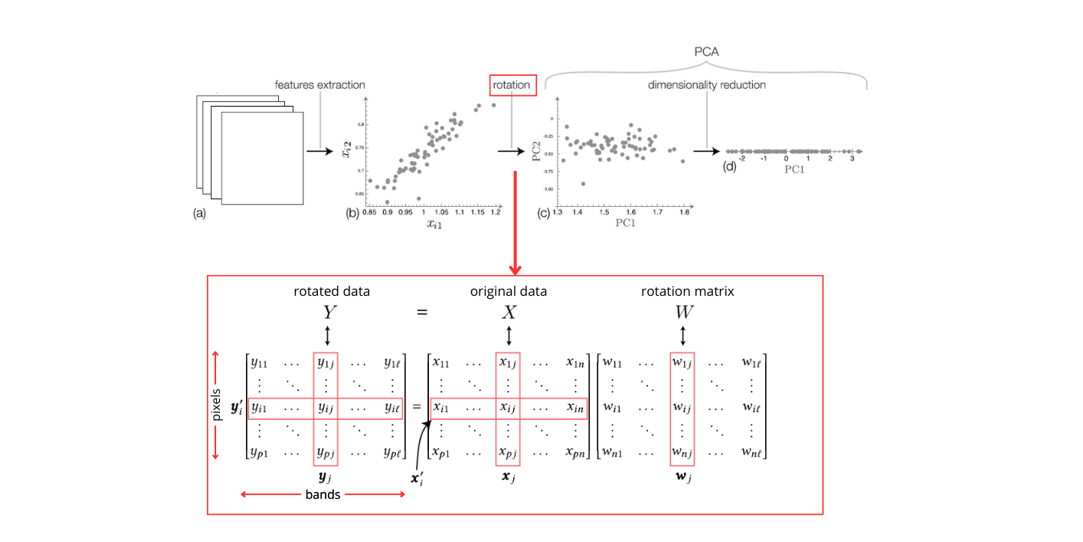

## 1. <a id='sec1'></a> Import useful libraries and PRISMA coregistered image
[Back to top](#TOC_TOP)

In [ ]:
import rasterio
from rasterio.plot import show
from sklearn.decomposition import PCA
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import os

In [ ]:
# Import functions and set auto-reload
from functions import *
%load_ext autoreload
%autoreload 2

Firstly, select the multiband raster (i.e. coregistered PRISMA imagery).

In [ ]:
date_prisma_w = widgets.Dropdown(
    options=['2023-02-09', '2023-03-22', '2023-04-08', '2023-06-17', '2023-07-10'],
    value='2023-02-09',
    description='PRISMA date:',
    disabled=False,
    layout={'width': 'max-content'},
    style = {'description_width': 'initial'}
)
date_prisma_w

In [ ]:
sel_prisma_date = date_prisma_w.value
selected_prisma_image = 'PRISMA_outputs/coregistered/PR_'+ sel_prisma_date.replace('-', '') + '_30m.tif'
print(f"The selected date is -> PRISMA: {sel_prisma_date}.")

The following function manipulates the PRISMA image for the subsequent PCA analysis. Specifically, these steps are implemented: (1) bands containing all zeros are removed, by setting a very low threshold; (2) the image, which is originally organized as an array with dimension `(number of bands, number or rows, number of columns)`, is reorganized as an array with shape `(n_bands, n_pixels)`, where `n_pixels = n_rows * n_cols`; accordingly, each band is reorganized as a single vector; (3) finally, the two axes are switched so that the first axis contains the pixel values and the second axis contains the band number, i.e. `(n_pixels, n_bands)`. *This is a necessary step since the PCA module demands the input data to be passed with dimensions (number of features, number of samples)*.

In [ ]:
input_image, original_image, metadata, n_bands = prepare_input_pca(selected_prisma_image)

## 2. <a id='sec2'></a>Perform the PCA with *scikit-learn*
[Back to top](#TOC_TOP)

The following function performs the PCA on the input PRISMA image. The number of PCs computed and returned equals the number of PRISMA bands. The output of `pca.transform` are indeed the PCs. The function reshapes the array so that the PCs are represented as matrixes.

In [ ]:
pca, pc_transf_reshaped = perform_pca(n_bands, original_image, input_image)
pc_transf_reshaped.shape

## 3. <a id='sec3'></a>Plot the results of the PCA
[Back to top](#TOC_TOP)

The **explained variance** (or **eigenvalue**) shows the variance that can be attributed to each of the PCs. The explained variance quantifies the amount of the total variance held by each component. The eigenvalues' decreasing order implies that the first PCs have the largest explained variances.

The explained variance can be accessed through `pca.explained_variance_` (*amount of variance explained by each of the selected components*) or `pca.explained_variance_ratio_` (*percentage of variance explained by each of the selected components*;. if `n_components` is not set then all components are stored and the sum of the ratios equals 1).

Get the explained variance for each component and the cumulative variance:

In [ ]:
variance_ratios = pca.explained_variance_ratio_
cumulativeVar = np.cumsum(variance_ratios)

Verify that the cumulative explained variance sums to 1:

In [ ]:
np.sum(pca.explained_variance_ratio_)

With the following widget, the user can select the number of PCs to visualize in the explained variance plot. Suggestion: for a more readable plot, select a small number of components (e.g. < 20).

In [ ]:
style = {'description_width': 'initial'}
pc_w = widgets.IntSlider(
    value=10,
    min=1,
    max=n_bands,
    step=1,
    description='Select PC bands to plot:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style = style
)
pc_w

In [ ]:
x_bar_components = pc_w.value

Plot interactively, with `plotly`, the explained variance ratio and the cumulative explained variance ratio.

In [ ]:
plot_explained_var(x_bar_components, pca, cumulativeVar)

The **eigenvectors** $w_j$ are normalized, and thus indicate only the direction of the PCs. Eigenvectors are stored in `pca.components_` (*principal axes in feature space, representing the directions of maximum variance in the data; equivalently, the right singular vectors of the centered input data, parallel to its eigenvectors: the components are sorted by decreasing explained variance*).

Another approach often used to interpret and analyse a PCA transformation is to define the **loading vectors** as $f_j = \sqrt{\lambda_j} w_j$.

Beyond the PC's direction, loadings vectors contains information about the explained variance along that direction.

In [ ]:
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_

In [ ]:
loadings = eigenvectors.T * np.sqrt(eigenvalues)

Plot the factor loadings in the PCs plane: this allows us to detect the relationship between the original features (bands) and the new PCs having the maximum explained variance.

The user can select the PCs to be used as x and y axes in the plot, as well as the plot scale (i.e. logarithmic or linear).

In [ ]:
plot_loadings(loadings)

## 4. <a id='sec4'></a> Export the PCs to GeoTIFF
[Back to top](#TOC_TOP)

In this last section, the PCs are exported as a single GeoTIFF file for further analyses in a GIS environment. A plot with the PCs is also reported.

Select the number of PCs to export [*Recall that they are already sorted by "importance"*].

In [ ]:
style = {'description_width': 'initial'}
nc2 = widgets.IntSlider(
    value=10,
    min=1,
    max=n_bands,
    step=1,
    description='Components to export',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style = style
)
nc2

In [ ]:
sel_pcs = nc2.value

Set path and name of the GeoTIFF file:

In [ ]:
out_path = 'PCs/PCs_'+ sel_prisma_date.replace('-', '') +'_30m.tif'

The following function creates a GeoTIFF file at the specified path, with the selected number of PCs.

In [ ]:
export_pc(pc_transf_reshaped, sel_pcs, metadata, out_path)

Finally, the following function allows the user to interactively display the PCs. The user can select the PC to visualize. Also, the function exports a masked GeoTIFF file containing the PCs which may be useful for visualization in QGIS.

In [ ]:
plot_pc(selected_prisma_image, out_path)